## **Deep Learning for Causal Inference by Vikas Ramachandra**

Applying the concepts from the "Deep Learning for Causal Inference" paper authored by Vikas Ramachandra to the data_for_churn_analysis dataset

link to the paper: <a>https://arxiv.org/abs/1803.00149</a>

In [61]:
# DA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ML
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

# Metrics
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error



In [4]:
# Loading dataset
df = pd.read_csv('data_for_churn_analysis.csv')

In [5]:
df.shape

(104143, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104143 entries, 0 to 104142
Data columns (total 18 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   device                                 104025 non-null  object 
 1   first_payment_amount                   104143 non-null  int64  
 2   age                                    104001 non-null  float64
 3   city                                   98301 non-null   object 
 4   number_of_cards                        103671 non-null  float64
 5   payments_initiated                     103671 non-null  float64
 6   payments_failed                        103671 non-null  float64
 7   payments_completed                     103671 non-null  float64
 8   payments_completed_amount_first_7days  103671 non-null  float64
 9   reward_purchase_count_first_7days      80879 non-null   float64
 10  coins_redeemed_first_7days             103671 non-null  

In [7]:
# null values?
print(f"{df.isnull().sum().sum()=}")
print(f"perc of dataset missing {df.isnull().sum().sum()/df.shape[0]}")

df.isnull().sum().sum()=37490
perc of dataset missing 0.3599857887712088


In [8]:
# proportion of people who have churned
df['is_churned'].value_counts(normalize=True)

is_churned
0    0.713192
1    0.286808
Name: proportion, dtype: float64

### 1. **Impact of Referrals on Customer Acquisition and Retention**:
   - Research Question: Do customers acquired through referrals (`is_referral`) exhibit different behaviors and retention rates compared to non-referred customers?
   - Treatment: Customer acquisition through referrals
   - Outcome: Customer behavior (e.g., `payments_initiated`, `payments_completed`, `visits_feature_1`, `visits_feature_2`) and churn (`is_churned`)
   - Potential Confounders: `device`, `age`, `city`, `number_of_cards`, `payments_failed`, `payments_completed_amount_first_7days`, `reward_purchase_count_first_7days`, `coins_redeemed_first_7days`, `given_permission_1`, `given_permission_2`

$$Y_i = f(T_i, X_i, \epsilon_i)$$

Where:

- $Y_i$ represents the outcome variable `is_churned` for customer $i$
- $T_i$ is the treatment variable `is_referral`, indicating whether customer $i$ was acquired through a referral
- $X_i$ represents the vector of potential confounding variables for customer $i$, such as `device`, `age`, `city`, `number_of_cards`, `payments_failed`, `payments_completed_amount_first_7days`, `reward_purchase_count_first_7days`, `coins_redeemed_first_7days`, `given_permission_1`, `given_permission_2`
- $\epsilon_i$ is the error term, accounting for unobserved factors affecting the outcome
- $f$ is an unknown function that maps the treatment, confounders, and error term to the outcome

In [9]:
# -------------- DATA PREPROCESSING --------------------

# Encoding using label encoding technique
obj_cols = df.select_dtypes(include='object').columns # grabs object dtypes columns
le = LabelEncoder() # creates LabelEncoder instance
for col in obj_cols:
    df[col] = le.fit_transform(df[col]) # encodes each column

df['is_referral'] = np.where(df['is_referral'] == True, 1, 0)


# -------------- IMPUTING MISSING VALUES --------------------
missing_cols = df.columns[df.isna().any()].tolist()
for col in missing_cols:
    df[col] = df[col].fillna(df[col].mean())


# -------------- DATA SPLIT --------------------

confounders = [
    'device',
    'age',
    'city',
    'number_of_cards',
    'payments_failed',
    'payments_completed_amount_first_7days',
    'reward_purchase_count_first_7days',
    'coins_redeemed_first_7days',
    'given_permission_1',
    'given_permission_2',
    'is_referral' # treatment
]

y = df['is_churned']
X = df[confounders]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)
Y_train, Y_test = train_test_split(y, test_size=0.2, random_state=42)

### 1. **Generalized Neighbor Matching using Autoencoders**

The paper proposes using autoencoders, a type of deep neural network, for dimensionality reduction while preserving the local neighborhood structure of the data. This is useful for generalized neighbor matching to estimate individual treatment effects (ITEs).

The key points are:

* In high dimensions, traditional neighbor matching methods like k-nearest neighbors struggle
* Autoencoders can learn a low-dimensional representation that captures the manifold structure
* This low-dimensional encoding preserves local neighborhoods for accurate neighbor identification
* Experiments show autoencoders outperform methods like manifold learning for ITE estimation

#### **PCA**

In [62]:
# Create a PCA instance
pca = PCA(n_components=3)  # Choose the number of components you want to keep

# Fit PCA to the scaled data
pca.fit(X_train)

# Transform the data to the new feature space
transformed_data = pca.transform(X_train)

In [64]:
X_train

,device,age,city,number_of_cards,payments_failed,payments_completed_amount_first_7days,reward_purchase_count_first_7days,coins_redeemed_first_7days,given_permission_1,given_permission_2,is_referral
70066,25,34.0,438,3.0,1.0,22.0,1.000000,3.0,1,1,1
51130,67,31.0,5,0.0,0.0,7.0,2.042075,0.0,1,0,0
88048,69,39.0,438,2.0,0.0,309.0,4.000000,303.0,1,0,0
100860,39,53.0,430,1.0,0.0,17.0,0.000000,17.0,1,0,1
25182,69,27.0,689,0.0,1.0,2.0,2.042075,0.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
54886,51,31.0,544,0.0,0.0,0.0,2.042075,0.0,1,1,1
76820,69,35.0,438,2.0,0.0,10.0,1.000000,3.0,0,0,1
103694,42,67.0,259,3.0,0.0,19.0,0.000000,0.0,1,0,1
860,2,22.0,63,1.0,0.0,41.0,2.000000,20.0,1,1,0


In [63]:
transformed_data

array([[-79.33875926, -35.69067607,  -6.15759073],
       [352.86328079, -63.69511059,  -1.57449548],
       [-68.95579316, 341.77407004, 166.25225727],
       ...,
       [ 99.36083023, -44.82026996,  -7.23203598],
       [296.29345832, -22.21283644,   2.51618841],
       [253.58859779, -38.57679299,   7.35293041]])

#### **Manifold Learning**

#### **Autoencoder**

In [10]:
input_dim = X.shape[1]  # Features count

# Input layer
input_layer = Input(shape=(input_dim, ))

# Encoder: Reduce dimensionality
encoded_1 = Dense(64, activation='relu')(input_layer)
encoded_2 = Dense(32, activation='relu')(encoded_1)
encoded_3 = Dense(16, activation='relu')(encoded_2)
encoded_4 = Dense(8, activation='relu')(encoded_3)

# Decoder: Reconstruct the input
decoded_1 = Dense(16, activation='relu')(encoded_4)
decoded_2 = Dense(32, activation='relu')(decoded_1)
decoded_3 = Dense(64, activation='relu')(decoded_2)
decoded_4 = Dense(input_dim, activation='linear')(decoded_3)  # Final output layer

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoded_4)  # Ensure to output from the last decoding layer
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# ------------- FITTING MODEL ------------
autoencoder.fit(X_train, Y_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, Y_test))

Epoch 1/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 687.5041 - val_loss: 0.2796
Epoch 2/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2610 - val_loss: 0.2268
Epoch 3/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2202 - val_loss: 0.2155
Epoch 4/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2111 - val_loss: 0.2098
Epoch 5/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2091 - val_loss: 0.2069
Epoch 6/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2066 - val_loss: 0.2064
Epoch 7/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2084 - val_loss: 0.2046
Epoch 8/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2076 - val_loss: 0.2038
Epoch 9/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2070 - val_loss: 0.2031
Epoch 10/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2029 - val_loss: 0.2032
Epoch 11/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2033 - val_loss: 0.2018
Epoch 12/50
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

In [17]:
# ------------- MODEL INFERENCE ------------
encoder = Model(inputs=input_layer, outputs=decoded_4)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
X_encoded = encoder.predict(X)

2604/2604 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step
651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step
3255/3255 ━━━━━━━━━━━━━━━━━━━━ 3s 842us/step


In [24]:
mae_autoencoder = mean_absolute_error(X_test, X_test_encoded)

#### **Evaluating Each Method (PCA, Manifold and Autoencoder) based on the paper**


Next, to compare B. manifold learning and C. autoencoders, We also compute the estimated treatment effect for each point (ITE), and the average absolute error of ITE for B. manifold learning and C. Autoencoder, over all the data points in the test set.
- Mean Absolute error (ITE,autoencoder: 3.7127,
- Mean absolute error (ITE, Manifold learning): 4.4540
- Thus, autoencoder error is 20.27% lesser than manifold learning estimate for the ITE.

In [25]:
mae_autoencoder

47.729490214490625

---

### 2. **Deep Neural Networks (DNNs) for Propensity Score Matching**

Propensity score matching is a popular technique, but traditionally uses logistic regression for propensity score estimation. The paper proposes using deep neural network classifiers instead, presenting a model called PropensityNet.

The key points are:

* DNNs can potentially capture complex non-linear relationships better than logistic regression
* PropensityNet is trained to estimate propensity scores as a binary classification problem
* Experiments show PropensityNet outperforms logistic regression for propensity score estimation
* This leads to better matching of treated and untreated units for ITE calculation

In [44]:
# Regular Logistic Regression
log_reg = LogisticRegression(max_iter = 10000).fit(X_train, Y_train)
preds = log_reg.predict_proba(X_test)

In [45]:
# assuming a 0.5 threshold
accuracy_score_logistic_regression = accuracy_score(Y_test, (preds[:, 1] > 0.5).astype('int'))

In [53]:
# mae
mae_logistic_regression = mean_absolute_error(Y_test, (preds[:, 1] > 0.5).astype('int'))

In [46]:
accuracy_score_logistic_regression

0.7379134860050891

In [54]:
mae_logistic_regression

0.26208651399491095

---

In [32]:
# -------------- PROPENSITY NET (TensorFlow) --------------------

# Define the model using the Sequential API
model = Sequential([
    Dense(64, input_shape=(11,), activation='relu'),  # Input layer with 11 features and first hidden layer with 64 neurons
    Dense(64, activation='relu'),  # Second hidden layer
    Dense(64, activation='relu'),  # Third hidden layer
    Dense(32, activation='relu'),  # Fourth hidden layer
    Dense(16, activation='relu'),  # Fifth hidden layer
    Dropout(0.3),  # Dropout layer
    Dense(1, activation='sigmoid')  # Output layer
])

# Compile the model with binary cross-entropy loss and the Adam optimizer
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])  # Include accuracy if you want to monitor it during training


# Train the model
history = model.fit(X_train, Y_train, epochs=20)  # Specify the number of epochs according to your training needs

Epoch 1/20


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2604/2604 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7197 - loss: 0.6931
Epoch 2/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7820 - loss: 0.5139
Epoch 3/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7932 - loss: 0.4951
Epoch 4/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7955 - loss: 0.4853
Epoch 5/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7959 - loss: 0.4807
Epoch 6/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7979 - loss: 0.4745
Epoch 7/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7984 - loss: 0.4740
Epoch 8/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7974 - loss: 0.4715
Epoch 9/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.7971 - loss: 0.4704
Epoch 10/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.7962 - loss: 0.4703
Epoch 11/20
2604/2604 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8025 - loss: 0.4643
Epoch 12/20
2604/2604 ━━━━━━━━━━━━━━━━━━━

In [33]:
preds_dnn = model.predict(X_test)

651/651 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step


In [36]:
preds_dnn

array([[0.18189439],
       [0.22652817],
       [0.18503548],
       ...,
       [0.1632126 ],
       [0.13018931],
       [0.11091483]], dtype=float32)

In [48]:
accuracy_score_propensity_net = accuracy_score(Y_test, (np.squeeze(preds_dnn) > 0.5).astype('int'))

In [52]:
mae_propensity_net = mean_absolute_error(Y_test, (np.squeeze(preds_dnn) > 0.5).astype('int'))

#### **Evaluating Each Method (LogisticRegression, PropensityNet) based on the paper**


- Evaluate them based on accuracy

In [58]:
print('DNN for Propensity Score Matching')
pd.DataFrame({'Method': ['Propensity Net', 'Logistic Regression'],
              'Accuracy Score': [accuracy_score_propensity_net, accuracy_score_logistic_regression ],
              'Mean Absolute Misclassification Error': [mae_propensity_net, mae_logistic_regression]})


DNN for Propensity Score Matching


,Method,Accuracy Score,Mean Absolute Misclassification Error
0,Propensity Net,0.803639,0.196361
1,Logistic Regression,0.737913,0.262087


<Axes: >

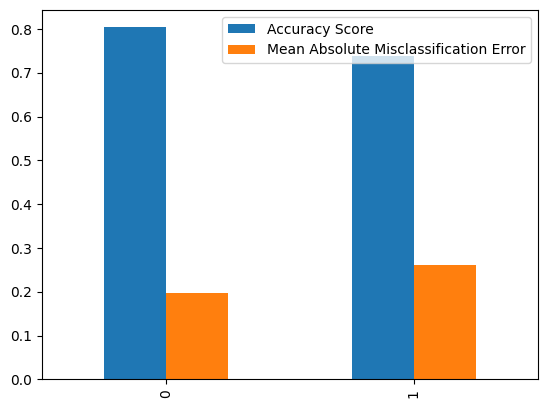

In [59]:
pd.DataFrame({'Method': ['Propensity Net', 'Logistic Regression'],
              'Accuracy Score': [accuracy_score_propensity_net, accuracy_score_logistic_regression ],
              'Mean Absolute Misclassification Error': [mae_propensity_net, mae_logistic_regression]}).plot(kind='bar')

In [60]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,141 (137.27 KB)

 Trainable params: 11,713 (45.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 23,428 (91.52 KB)

-----

-------

Other code (ignore)

In [ ]:
# model = nn.Sequential(
#                 nn.Linear(in_features=11, out_features=64),
#                 nn.ReLU(),
#                 nn.Linear(in_features=64, out_features=64),
#                 nn.ReLU(),
#                 nn.Linear(in_features=64, out_features=64),
#                 nn.ReLU(),
#                 nn.Linear(in_features=64, out_features=32),
#                 nn.ReLU(),
#                 nn.Linear(in_features=32, out_features=16),
#                 nn.ReLU(),
#                 nn.Dropout(p=0.3),
#                 nn.Linear(in_features=16, out_features=1),
#                 nn.Sigmoid()
#             )


# # -------------- LOSS FUNCTION (Binaty Cross Entropy) & OPTIMIZER (Adam) --------------------
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


# # ------- Tensors & Dataloaders --------------
# # converting to pytorch tensors
# X_tensor = torch.tensor(X.to_numpy(), dtype=torch.float32)
# y_tensor = torch.tensor(y.to_numpy(), dtype=torch.float32)

# # Dataloaders
# train_dataset = TensorDataset(X_tensor, y_tensor)
# train_dataloader = DataLoader(train_dataset, batch_size=220, shuffle=True)



# total_params = sum(p.numel() for p in model.parameters())
# print("Total number of parameters:", total_params)



# -------------- TRAINING LOOP --------------------

# EPOCHS = 20
# for epoch in range(EPOCHS):
#     epoch_loss = 0
#     for inputs, label in train_dataloader:

#         # ---- FORWARD PASS -----
#         pred = model(inputs)
#         pred = pred.squeeze(1)
#         loss = criterion(pred, label)

#         # ----- BACKPROPAGATION -----
#         loss.backward() # calculating gradients
#         optimizer.step() # multiplies learning_rate * gradient, which is your step size or by how much you update the weights

#         # loss
#         epoch_loss += loss.item()
#     epoch_loss /= len(train_dataloader)
#     print("epoch: {0} training loss {1}".format(epoch, epoch_loss))



# -------------- EVALUATING MODEL --------------------
# # Make predictions
# model.eval()  # Set the model to evaluation mode
# predictions = []
# with torch.no_grad():  # Disable gradient tracking during inference
#     for batch in train_dataloader:
#         inputs, labels = batch
#         pred = model(inputs)
#         pred = pred.squeeze(1)  # If your model outputs a single value per sample
#         predictions.append(pred)


# # Concatenate predictions into a single tensor
# predictions_tensor = torch.cat(predictions)

# # Convert predictions to numpy array
# predictions_array = predictions_tensor.numpy()